Original data shape: (15480, 14), Cleaned data shape: (10409, 14)


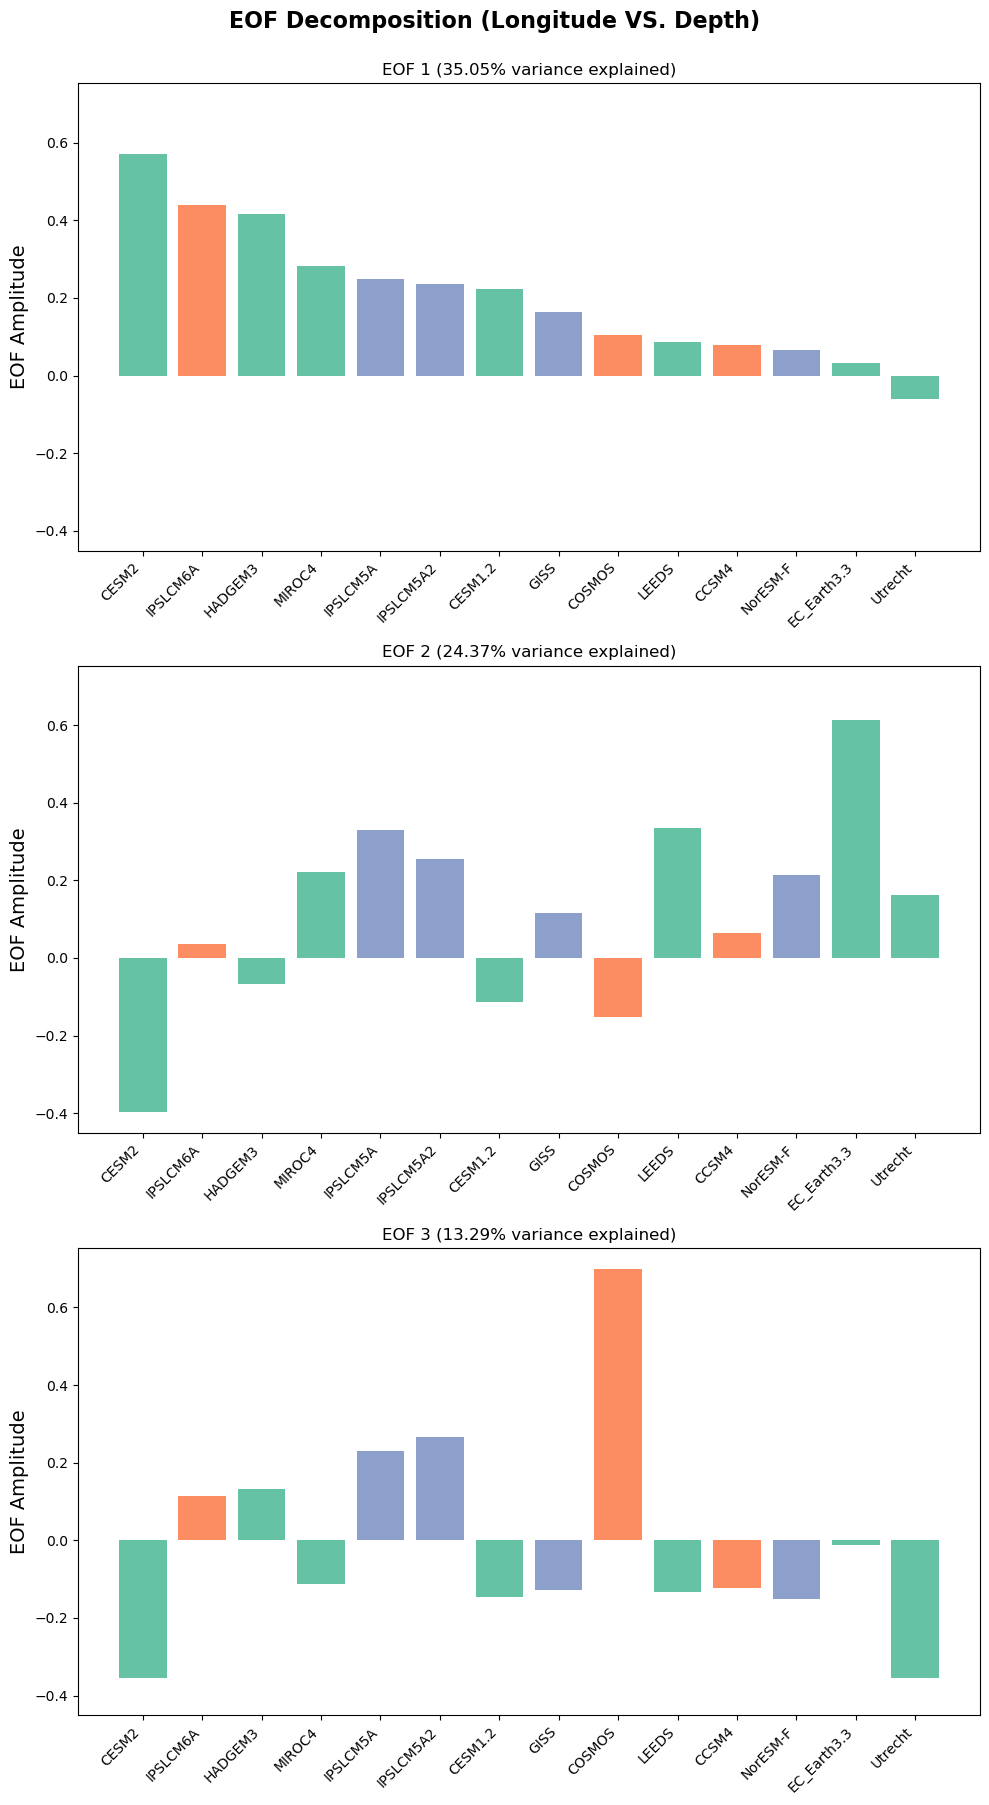

In [2]:
import xarray as xr
import numpy as np 
import pandas as pd
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
suppress_warnings = True 
suppress_plots = False 
if suppress_warnings:
    warnings.filterwarnings("ignore")
if suppress_plots:
    import matplotlib
    matplotlib.use("Agg")

ds = xr.open_dataset('/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/all_models.nc')

# Define the models to drop
models_to_drop = ['MMM', 'MCA Late Plio', 'MCA Early Plio']

# Select only the models that are not in the list
ds = ds.drop_vars(models_to_drop)

# Extract models while dropping MMM and MCA
models_to_keep = [model for model in ds.data_vars if model not in ['MMM', 'MCA Late Plio', 'MCA Early Plio']]
data_matrix = np.array([ds[model].values.flatten() for model in models_to_keep]).T

# Find and remove rows that contain NaNs
nan_mask = np.isnan(data_matrix).any(axis=1)
clean_data_matrix = data_matrix[~nan_mask]

print(f"Original data shape: {data_matrix.shape}, Cleaned data shape: {clean_data_matrix.shape}")

# Perform EOF Analysis
pca = PCA(n_components=3)
pca_result = pca.fit_transform(clean_data_matrix)
EOFs = pca.components_

# Convert EOFs back to xarray
eof_ds = xr.Dataset({
    f'EOF{i+1}': (['model'], EOFs[i])
    for i in range(EOFs.shape[0])
}, coords={'model': models_to_keep})

# Define number of EOFs to visualize
num_components = min(5, len(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_ * 100

# Create figure with subplots
fig, axes = plt.subplots(num_components, 1, figsize=(10, 18), sharey=True)

# FIRST: Get the sorting order from EOF1
eof1_values = eof_ds['EOF1'].values
sorted_indices = np.argsort(eof1_values)[::-1]  # Descending order
sorted_models = np.array(models_to_keep)[sorted_indices]

# Define models to highlight and their colors
highlight_models = {
    'CESM2': '#66c2a5',
    'CESM1.2': '#66c2a5',
    'EC_Earth3.3': '#66c2a5',
    'HADGEM3': '#66c2a5',
    'MIROC4': '#66c2a5',
    'Utrecht': '#66c2a5',
    'LEEDS': '#66c2a5',
    'CCSM4': '#fc8d62',
    'COSMOS': '#fc8d62',
    'IPSLCM6A': '#fc8d62',
    'GISS': '#8da0cb',
    'NorESM-F': '#8da0cb',
    'IPSLCM5A': '#8da0cb',
    'IPSLCM5A2': '#8da0cb',
    
}
for i in range(num_components):
    ax = axes[i]
    
    # Get values in EOF1-sorted order
    sorted_eof_values = eof_ds[f'EOF{i+1}'].values[sorted_indices]
    
    # Assign colors: default 'steelblue', but use highlight_models if specified
    colors = [highlight_models.get(model, 'steelblue') for model in sorted_models]
    
    # Plot with color coding
    bars = ax.bar(sorted_models, sorted_eof_values, color=colors)
    ax.set_title(f'EOF {i+1} ({variance[i]:.2f}% variance explained)')
    ax.set_ylabel('EOF Amplitude', fontsize=14)
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')

fig.suptitle('EOF Decomposition (Longitude VS. Depth)', fontsize=16, fontweight='bold', y=1)
plt.tight_layout()
#plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/EOF_Deconposition_LongitudeVSDepth.pdf', dpi=300, bbox_inches="tight")
plt.show()